In [9]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [29]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pandas as pd


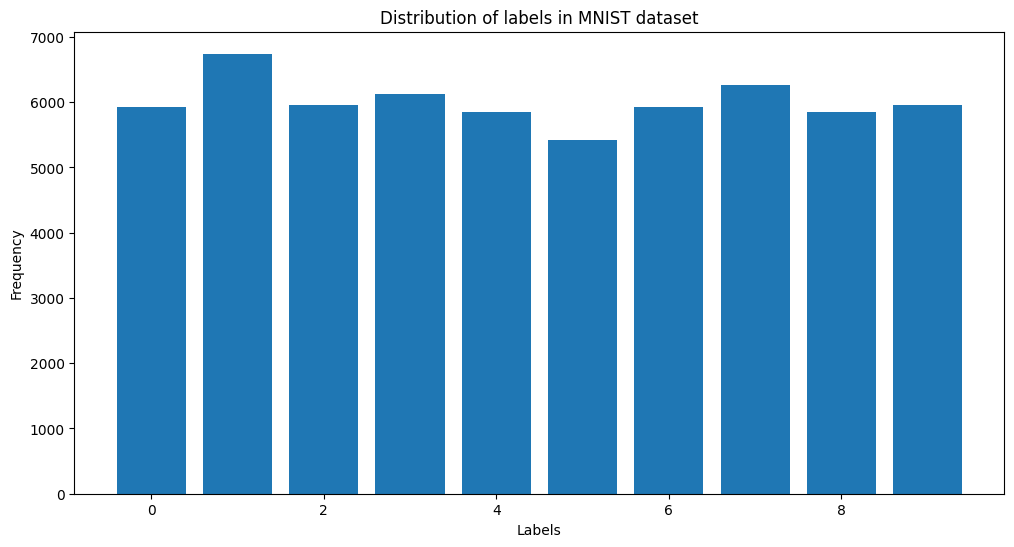

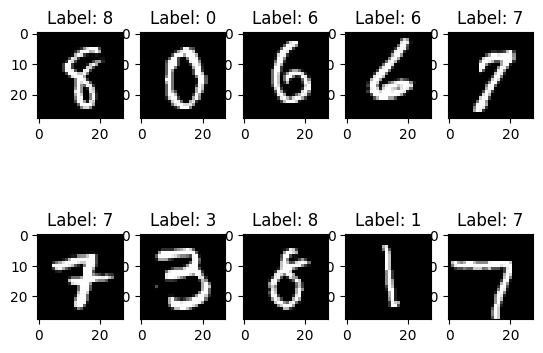

Class imbalance: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [3]:


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, shuffle=True, batch_size=32)  # Batch size can be changed

# 1.1) Distribution of the various labels
label_dist = mnist_data.targets.bincount()
plt.figure(figsize=(12, 6))
plt.bar(np.arange(10), label_dist.numpy())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of labels in MNIST dataset')
plt.show()

# 1.2) Visualize samples of images from each class
images, labels = next(iter(data_loader))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
plt.show()

# 1.3) Check for class imbalance
print("Class imbalance:", label_dist)

# 1.4) Partition the dataset
# Train: 60%, Val: 20%, Test: 20%
train_size = int(0.6 * len(mnist_data))
val_size = test_size = int(0.2 * len(mnist_data))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(mnist_data, [train_size, val_size, test_size])

# For 1.5) we will define the function after building the model to have the necessary context


In [4]:
torch.device("mps")

device(type='mps')

In [5]:
print(data_loader)

In [40]:
import torch.nn as nn
import torch.optim as optim

# 2.1) Construct the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.LogSoftmax(dim=1)(x)
        return output

In [41]:
# Initialize the model
model = Net().to(mps_device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 2.3) Train the model
epochs = 10  # Can be changed
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(mps_device), target.to(mps_device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Training loss: {train_loss/len(data_loader)}')

Epoch 1, Training loss: 0.24424338138848542
Epoch 2, Training loss: 0.10820985437892378
Epoch 3, Training loss: 0.08398340652448436
Epoch 4, Training loss: 0.06958763393882351
Epoch 5, Training loss: 0.05934013922329371
Epoch 6, Training loss: 0.0542861853946272
Epoch 7, Training loss: 0.048297977266837065
Epoch 8, Training loss: 0.04445521800354278
Epoch 9, Training loss: 0.040142251511855284
Epoch 10, Training loss: 0.03710247867443928


In [48]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(mps_device), target.to(mps_device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# 2.4) Evaluate the model

# Compute accuracy on the training set
train_accuracy = compute_accuracy(model, data_loader)
print(f'Training accuracy: {train_accuracy}')

# Compute accuracy on the validation set
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=32)
val_accuracy = compute_accuracy(model, val_loader)
print(f'Validation accuracy: {val_accuracy}')

# Compute accuracy on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=32)
test_accuracy = compute_accuracy(model, test_loader)
print(f'Test accuracy: {test_accuracy}')

Training accuracy: 99.81833333333333
Validation accuracy: 99.76666666666667
Test accuracy: 99.06


/opt/homebrew/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


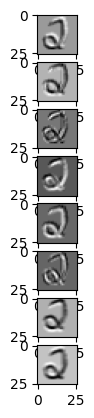

In [8]:
def visualize_feature_maps(model, image, selected_layer):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    # Registering hook for the selected layer
    hook = selected_layer.register_forward_hook(hook_fn)

    # Preprocess the image and pass the image through the network
    with torch.no_grad():
        
        model(image.to(mps_device))  # Ensure the image tensor is on the same device as the model

    # Remove the hook
    hook.remove()

    # Display feature maps
    output = activations[0]  # As we registered hook to only one layer
    fig, axarr = plt.subplots(min(output.size(1), 8))  # It will display 8 feature maps or less
    for i in range(min(output.size(1), 8)):
        axarr[i].imshow(output[0][i].cpu().numpy(), cmap='gray')  # Plotting the ith feature map

# Selecting the layer you are interested in, for example, the first convolutional layer
selected_layer = model.conv1  # or any other layer you're interested in
# Choose an image from your dataset
image, _ = next(iter(data_loader))  # Grabbing a single image from the data loader
image = image.squeeze(0)  # Adding a batch dimension

visualize_feature_maps(model, image, selected_layer)


# Autoencoders

In [12]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [13]:
# Hyperparameters
input_size = 784  # MNIST image size: 28x28
hidden_size = 400
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Load the MNIST dataset
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Additive Gaussian Noise
def add_noise(img, noise_factor=0.5):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

# Denoising Autoencoder Model
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.view(images.size(0), -1)
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/5], Step [100/600], Loss: 0.0485
Epoch [1/5], Step [200/600], Loss: 0.0361
Epoch [1/5], Step [300/600], Loss: 0.0310
Epoch [1/5], Step [400/600], Loss: 0.0251
Epoch [1/5], Step [500/600], Loss: 0.0235
Epoch [1/5], Step [600/600], Loss: 0.0204
Epoch [2/5], Step [100/600], Loss: 0.0208
Epoch [2/5], Step [200/600], Loss: 0.0193
Epoch [2/5], Step [300/600], Loss: 0.0189
Epoch [2/5], Step [400/600], Loss: 0.0185
Epoch [2/5], Step [500/600], Loss: 0.0181
Epoch [2/5], Step [600/600], Loss: 0.0164
Epoch [3/5], Step [100/600], Loss: 0.0177
Epoch [3/5], Step [200/600], Loss: 0.0166
Epoch [3/5], Step [300/600], Loss: 0.0156
Epoch [3/5], Step [400/600], Loss: 0.0152
Epoch [3/5], Step [500/600], Loss: 0.0157
Epoch [3/5], Step [600/600], Loss: 0.0165
Epoch [4/5], Step [100/600], Loss: 0.0164
Epoch [4/5], Step [200/600], Loss: 0.0156
Epoch [4/5], Step [300/600], Loss: 0.0154
Epoch [4/5], Step [400/600], Loss: 0.0155
Epoch [4/5], Step [500/600], Loss: 0.0153
Epoch [4/5], Step [600/600], Loss:

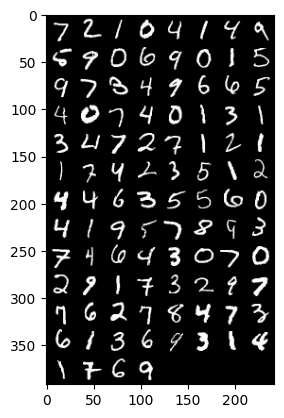

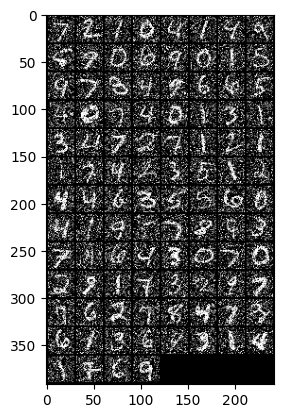

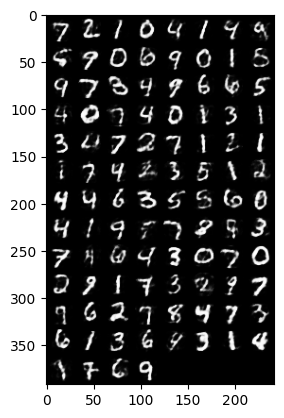

In [17]:
# Visualizing original and denoised images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, _ = next(iter(test_loader))
noisy_images = add_noise(images.view(images.size(0), -1))

# Original images
imshow(torchvision.utils.make_grid(images))
# Noisy images
imshow(torchvision.utils.make_grid(noisy_images.view(batch_size, 1, 28, 28)))
# De-noised images
outputs = model(noisy_images)
imshow(torchvision.utils.make_grid(outputs.view(batch_size, 1, 28, 28)))


In [18]:
# Training CNN on denoised images

# Initialize the model
model = Net().to(mps_device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Training the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = add_noise(images.view(images.size(0), -1))
        images, labels = images.to(mps_device), labels.to(mps_device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluating the model on test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = add_noise(images.view(images.size(0), -1))
        images, labels = images.to(mps_device), labels.to(mps_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print(f'Test Accuracy of the model on the {total} test images: {100 * correct / total}%')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 784]

/opt/homebrew/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


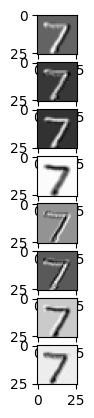

In [19]:
# 2.4) Visualize the feature maps of the first convolutional layer of the CNN model trained on denoised images

# Selecting the layer you are interested in, for example, the first convolutional layer
selected_layer = model.conv1  # or any other layer you're interested in
# Choose an image from your dataset
image, _ = next(iter(test_loader))  # Grabbing a single image from the data loader
image = image.squeeze(0)  # Adding a batch dimension

visualize_feature_maps(model, image, selected_layer)

In [28]:
from icecream import ic

In [30]:
import os
#Creating a dataframe for the images and its path
def get_df(directory_path):
    

    # Initialize lists to store data
    file_names = []
    class_labels = []
    one_hot_labels = []
    file_paths = []  

    
    num_classes = 10

    # Iterate through the subdirectories in the main directory
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.png'):  
                file_name = os.path.splitext(file)[0]  
                parts = file_name.split('_')
#                 print('parts',parts)
            
                if len(parts) == 2:
                    # Extract the first and second digits
                    first_digit, second_digit = map(int, parts)
#                     print('parts0', parts[0])
#                     print('parts00', parts[0][0])
#                     print('parts01', parts[0][1])
                    first_digit = str(first_digit)
#                     print('first digit', first_digit)
                    second_digit = str(second_digit)
#                     print('second digit', second_digit)
                    ic(parts)
                    findex = int(parts[0][0])
                    sindex = int(parts[0][1])

                    file_names.append(f"{file_name}.png")
        
                    # Append the one-hot class labels
                    one_hot = [0] * num_classes
                    one_hot[findex] = 1
                    one_hot[sindex] = 1
                    one_hot_labels.append(one_hot)

                    labels = [findex,sindex]
                    # Append the class labels (first and second digit)
                    class_labels.append(labels)

                    # Append the file path
                    file_paths.append(os.path.join(root, file))

    # Create a DataFrame
    data = {'file_name': file_names, 'file_path': file_paths}
    for i in range(num_classes):
        data[str(i)] = [label[i] for label in one_hot_labels]
    data['class'] = class_labels

    df = pd.DataFrame(data)
    return df

def load_image(file_path):
    img = Image.open(file_path)
    img_array = np.array(img)
    return img_array


def one_hot_encode(row):
    one_hot_list = [int(i) for i in row.values]
    return np.array(one_hot_list)

train_path ='/Users/aaryansharma/Downloads/double_mnist_seed_123_image_size_64_64'
df_train = get_df(train_path)
df_train['image_array'] = df_train['file_path'].apply(load_image)
columns_to_include = ['0','1','2','3','4','5','6','7','8','9']
selected_df = df_train.loc[:, columns_to_include]
selected_df['one_hot'] = selected_df.apply(one_hot_encode, axis=1)
y_train =  np.array(selected_df['one_hot'].values)
X_train = df_train['image_array'].values


ic| parts: ['6', '92']


IndexError: string index out of range

In [21]:
X_train = images.reshape(-1, 28*28)
X_train.shape

(64000, 784)

In [22]:
import torch.nn as nn

class MultiMNISTMLP(nn.Module):
    def __init__(self):
        super(MultiMNISTMLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 20)  # 2 digits * 10 classes per digit

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        return self.fc4(x)

# Permuted MNIST

In [38]:
# Load the permuted_mnist dataset
permuted_mnist = np.load('/Users/aaryansharma/Downloads/permuted_mnist.npz', allow_pickle=True)
print(permuted_mnist.files)
# Extract the train, test and validation sets
X_train = permuted_mnist['train_images']
y_train = permuted_mnist['train_labels']
X_test = permuted_mnist['test_images']
y_test = permuted_mnist['test_labels']
ic(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ic| X_train.shape: (60000, 28, 28)
    y_train.shape: (60000,)
    X_test.shape: (10000, 28, 28)
    y_test.shape: (10000,)


['train_images', 'train_labels', 'test_images', 'test_labels']


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [34]:
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader for training and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


['train_images', 'train_labels', 'test_images', 'test_labels']

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 10) # 10 output classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10) # 10 output classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = torch.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(-1, 7 * 7 * 64)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [45]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001):
    model.to(mps_device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(mps_device), target.to(mps_device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.4f}")

# Training the models
mlp_model = MLP()
cnn_model = CNN()
print("Training MLP:")
train_model(mlp_model, train_loader, test_loader)
print("\nTraining CNN:")
train_model(cnn_model, train_loader, test_loader)


Training MLP:
Epoch: 1, Training Loss: 0.2658
Epoch: 2, Training Loss: 0.0948
Epoch: 3, Training Loss: 0.0627
Epoch: 4, Training Loss: 0.0467
Epoch: 5, Training Loss: 0.0317
Epoch: 6, Training Loss: 0.0266
Epoch: 7, Training Loss: 0.0211
Epoch: 8, Training Loss: 0.0173
Epoch: 9, Training Loss: 0.0165
Epoch: 10, Training Loss: 0.0115

Training CNN:
Epoch: 1, Training Loss: 0.1767
Epoch: 2, Training Loss: 0.0482
Epoch: 3, Training Loss: 0.0331
Epoch: 4, Training Loss: 0.0234
Epoch: 5, Training Loss: 0.0179
Epoch: 6, Training Loss: 0.0159
Epoch: 7, Training Loss: 0.0125
Epoch: 8, Training Loss: 0.0097
Epoch: 9, Training Loss: 0.0092
Epoch: 10, Training Loss: 0.0072


In [46]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(mps_device), target.to(mps_device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# For MLP Model
mlp_train_accuracy = compute_accuracy(mlp_model, train_loader)
mlp_test_accuracy = compute_accuracy(mlp_model, test_loader)
print(f"MLP Model - Training Accuracy: {mlp_train_accuracy:.2f}%, Testing Accuracy: {mlp_test_accuracy:.2f}%")

# For CNN Model
cnn_train_accuracy = compute_accuracy(cnn_model, train_loader)
cnn_test_accuracy = compute_accuracy(cnn_model, test_loader)
print(f"CNN Model - Training Accuracy: {cnn_train_accuracy:.2f}%, Testing Accuracy: {cnn_test_accuracy:.2f}%")



MLP Model - Training Accuracy: 99.72%, Testing Accuracy: 98.15%
CNN Model - Training Accuracy: 99.81%, Testing Accuracy: 99.06%


# Analysis

- We see that CNN performs better than MLP in permuted MNIST 
- CNNs are designed to work with image data and can learn spatial features from the images.
- In contrast, MLPs are designed to work with tabular data and do not take into account the spatial structure of the data.
- In permuted MNIST, the spatial structure of the image is not important for recognizing the digits, and yet CNNs learn these features well. Additionally, CNNs have fewer parameters than MLPs, which makes them less prone to overfitting.